In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
sns.set_theme(style="darkgrid")
import datetime
import matplotlib.pyplot as plt

In [24]:
from sktime.utils.plotting import plot_series, plot_correlations, plot_lags
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.model_selection import (ExpandingWindowSplitter)
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.arima import ARIMA
from matplotlib.pyplot import plot, yticks
from sktime.forecasting.arima import AutoARIMA
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError, MeanAbsoluteError, MeanAbsoluteScaledError

In [76]:
from typing import Union, Dict, List, Callable
import statsmodels
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.api as sm

import prophet
from prophet import Prophet
import bokeh
from bokeh.models import CustomJS, ColumnDataSource, Slider, Label, Div, HoverTool, Band, Span, BoxAnnotation
from bokeh.plotting import figure
from bokeh.palettes import Spectral11
import ipywidgets as widgets
from IPython.display import display
from typing import Union, Dict, List, Callable
from contextlib import contextmanager
import sys, os

In [25]:
# read data
df = pd.read_pickle('data/df_daily.pkl')
df.head()

,date,store_id,sales,promo_count,store_level,store_group,store_format,store_segment,opening_date,status,store_area,number_of_staff,province,channel
0,2017-08-07,307222,1527650.0,1,A,Trực thuộc,Phố,Mainstream,2011-01-11,Active,112.0,6.0,Hồ Chí Minh,Retail
1,2017-08-08,307222,0.0,0,A,Trực thuộc,Phố,Mainstream,2011-01-11,Active,112.0,6.0,Hồ Chí Minh,Retail
2,2017-08-09,307222,26627420.0,14,A,Trực thuộc,Phố,Mainstream,2011-01-11,Active,112.0,6.0,Hồ Chí Minh,Retail
3,2017-08-10,307222,10755720.0,9,A,Trực thuộc,Phố,Mainstream,2011-01-11,Active,112.0,6.0,Hồ Chí Minh,Retail
4,2017-08-11,307222,10216950.0,10,A,Trực thuộc,Phố,Mainstream,2011-01-11,Active,112.0,6.0,Hồ Chí Minh,Retail


## 1. EDA on sales

In [64]:
def add_datepart(df, fldname, inplace=False, drop=False):
    if not inplace: df = df.copy()        
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64
    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    
    attr = ['Year', 'Month', 'Day',  'Week', 'Dayofweek', 'Dayofyear']
#   attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear','Weekofyear',
#             'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    for n in attr: 
        if n == 'Week':
            df[targ_pre + n] = getattr(fld.dt.isocalendar(), n.lower())
            continue
        df[targ_pre + n] = getattr(fld.dt, n.lower())
        
    if drop: 
        df.drop(fldname, axis=1, inplace=True)
    if not inplace: 
        return df 
    
df_trainext = add_datepart(df.query('store_level=="D"'), fldname='date')
df_trainext.head()

,date,sales,store_level,Year,Month,Day,Week,Dayofweek,Dayofyear
2545,2017-08-17,10928470.0,D,2017,8,17,33,3,229
2546,2017-08-18,9023400.0,D,2017,8,18,33,4,230
2547,2017-08-19,6183850.0,D,2017,8,19,33,5,231
2548,2017-08-20,0.0,D,2017,8,20,33,6,232
2549,2017-08-21,0.0,D,2017,8,21,34,0,233


Bellow are some decomposition of the data. Key insights:
- Monthly trend: Sales usually peaked in Tet holidays, Independent day, Backtoschool, and Black Friday
- Weekly trend: Weekend, especially Sunday has the best sales

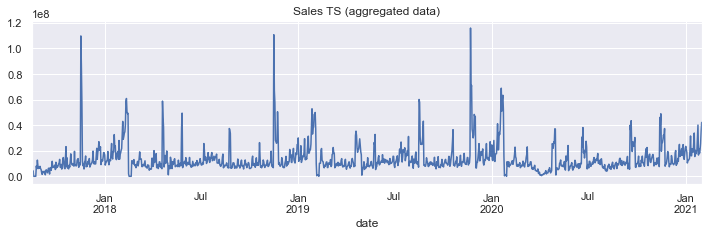

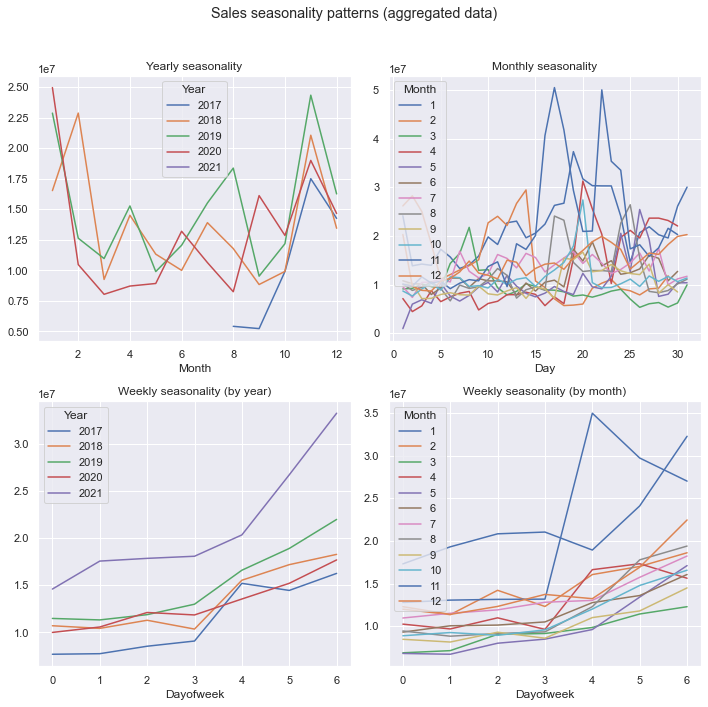

In [65]:
df_trainext.groupby('date').mean()['sales'].plot(figsize=(12,3), title='Sales TS (aggregated data)')

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
_ = pd.pivot_table(df_trainext, values='sales', columns='Year', index='Month').plot(title="Yearly seasonality", ax=ax[0,0])
_ = pd.pivot_table(df_trainext, values='sales', columns='Month', index='Day').plot(title="Monthly seasonality", ax=ax[0,1])
_ = pd.pivot_table(df_trainext, values='sales', columns='Year', index='Dayofweek').plot(title="Weekly seasonality (by year)", ax=ax[1,0])
_ = pd.pivot_table(df_trainext, values='sales', columns='Month', index='Dayofweek').plot(title="Weekly seasonality (by month)", ax=ax[1,1])
fig.suptitle('Sales seasonality patterns (aggregated data)')
fig.tight_layout(rect=[0, 0, 1, 0.96])

## 2. Data processing

In [26]:
#store_list = df['store_id'].unique()
# Remove non-relevant columns
df = df[['date', 'sales', 'store_level']]
df.head()

,date,sales,store_level
0,2017-08-07,1527650.0,A
1,2017-08-08,0.0,A
2,2017-08-09,26627420.0,A
3,2017-08-10,10755720.0,A
4,2017-08-11,10216950.0,A


In [27]:
# rename levels for convenience
df.replace({
    'A++': 'A',
    'A+': 'B',
    'A': 'C',
    'B': 'D',
    'C': 'E'}, inplace=True)

In [28]:
df.query('store_level=="A"')

,date,sales,store_level
5065,2017-08-09,8314900.0,A
5066,2017-08-10,7037470.0,A
5067,2017-08-11,13699430.0,A
5068,2017-08-12,50088170.0,A
5069,2017-08-13,11195610.0,A
...,...,...,...
6332,2021-01-27,56495801.0,A
6333,2021-01-28,34744840.0,A
6334,2021-01-29,64115900.0,A
6335,2021-01-30,125637810.0,A


Generated timeseries data for store level D


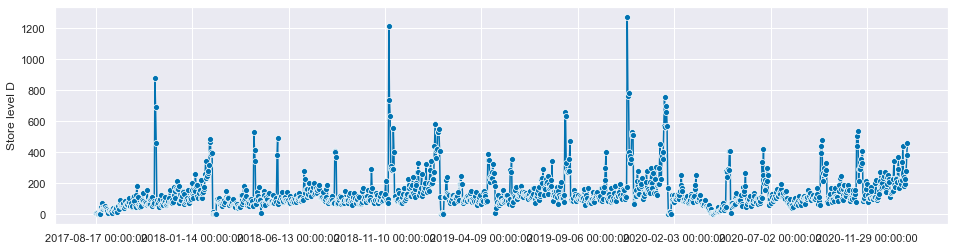

In [29]:
# df_lev['store_level'].value_counts()
def ts_datagen(data, store_level, printplot = True):
    '''Generate time series aggregated data for each store level'''
    # daily sum by level
    df_lev = data.groupby(['store_level', 'date'], as_index=False).sum()
    # level A
    df_lev = df_lev[df_lev['store_level'] == store_level]
    # time series of sales
    ts = df_lev.set_index('date')['sales'].rename('Store level ' + store_level)    
    ts = round(ts/1e6, 3)  # scale data
    ts.index.freq = 'D' 
    if printplot: plot_series(ts)
    print(f"Generated timeseries data for store level {store_level}")
    return ts

ts = ts_datagen(df,'D')

In [30]:
def get_windows(y, cv):
    """Generate windows"""
    train_windows = []
    test_windows = []
    for i, (train, test) in enumerate(cv.split(y)):
        train_windows.append(train)
        test_windows.append(test)
    return train_windows, test_windows
# %% use CV to score model after fitting
# function to evaluate model
def cv_eval(y_train, forecaster, cv, fh):
    results = pd.DataFrame()
    for i, (train, test) in enumerate(cv.split(y_train)):
        # split data
        y_train_cv, y_test_cv = y_train[train], y_train[test]

        # fit/update
        if i == 0:  # initial fit
            forecaster.fit(y_train_cv, fh=fh)
        else:
            forecaster.update(y_train_cv, update_params=False)

        # predict
        y_pred_cv = forecaster.predict(fh)

        # score
        score_MAE = scoring_MAE(y_test_cv, y_pred_cv)
        score_MAPE = scoring_MAPE(y_test_cv, y_pred_cv)
        score_MASE = scoring_MASE(y_test_cv, y_pred_cv, y_train=y_train_cv)

        # save results
        results = results.append({
            'y_test': y_test_cv,
            'y_pred_cv': y_pred_cv,
            'MAE': score_MAE,
            'MAPE': score_MAPE,
            'MASE': score_MASE,
            },
            ignore_index=True,
        )
    return results, forecaster

In [31]:
steps_ahead = 14
y_train = ts[:-steps_ahead]

# out-of-sample/test set
y_test_final = ts[-steps_ahead:]  # out-of-sample test set

scoring_MAPE = MeanAbsolutePercentageError()
scoring_MAE = MeanAbsoluteError()
scoring_MASE = MeanAbsoluteScaledError()

In [32]:
# %% ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# k-fold rolling cross validation
k = 4 # number of folds
sp = 7 # seasonal period
ini_window = len(y_train) - steps_ahead*k # initial train set to fit a model
fh = list(range(1, steps_ahead+1)) # forecast horizon
cv = ExpandingWindowSplitter(
    initial_window=ini_window, fh=fh, step_length=steps_ahead)

### 2.1. SNAIVE

In [33]:
# NAIVE
param_grid_NAIVE = ['last', 'mean', 'drift']
cv_res_NAIVE = []

# grid search for best param
for param in param_grid_NAIVE:
    # define model
    cv_mod_NAIVE = NaiveForecaster(sp=sp, strategy=param)
    # fit model to training data
    cv_mape_NAIVE = evaluate(cv_mod_NAIVE, cv, y_train, return_data=True)
    cv_res_NAIVE.append(
        round(np.mean(cv_mape_NAIVE['test_MeanAbsolutePercentageError']), 3))

cv_res_NAIVE = pd.DataFrame(
    {'param': param_grid_NAIVE, 'mape': cv_res_NAIVE}).sort_values('mape')
cv_res_NAIVE

C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\sktime\forecasting\naive.py:78: UserWarning: For the `drift` strategy, the `sp` value will be ignored.
  warn("For the `drift` strategy, the `sp` value will be ignored.")
C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\sktime\forecasting\naive.py:78: UserWarning: For the `drift` strategy, the `sp` value will be ignored.
  warn("For the `drift` strategy, the `sp` value will be ignored.")
C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\sktime\forecasting\naive.py:78: UserWarning: For the `drift` strategy, the `sp` value will be ignored.
  warn("For the `drift` strategy, the `sp` value will be ignored.")
C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\sktime\forecasting\naive.py:78: UserWarning: For the `drift` strategy, the `sp` value will be ignored.
  warn("For the `drift` strategy, the `sp` value will be ignored.")


,param,mape
1,mean,0.268
0,last,0.429
2,drift,0.491


In [34]:
# OOS score
tuned_SNAIVE = NaiveForecaster(sp=sp, strategy=cv_res_NAIVE.iloc[0, 0])
tuned_SNAIVE.fit(y_train)
pred_SNAIVE = tuned_SNAIVE.predict(y_test_final.index)
mape_SNAIVE = round(scoring_MAPE(y_test_final, pred_SNAIVE), 3)
print(f'Final OOS MAPE score: {mape_SNAIVE}')

# %%

Final OOS MAPE score: 0.598


### 2.2. ARIMA
#### Stationarity test

In [35]:
from statsmodels.tsa.stattools import adfuller, kpss

if adfuller(ts)[1] < 0.05:
    print('stationary')
else:
    print('not stationary')

if kpss(ts)[1] >= 0.05:
    print('stationary')
else:
    print('not stationary')

stationary
not stationary


C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\stattools.py:1850: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)


In [36]:
# AutoARIMA
# specify model & param grid
forecaster_AutoARIMA = AutoARIMA(sp=7,
                                 max_order=None,
                                 random=True,
                                 random_state=123,
                                 n_fits=10)

# fit & evaluate model
cv_results_AutoARIMA, forecaster_AutoARIMA = cv_eval(
    y_train,
    forecaster_AutoARIMA, 
    cv, fh
    )

forecaster_AutoARIMA.summary()
cv_results_AutoARIMA

C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Admin\AppD

,MAE,MAPE,MASE,y_pred_cv,y_test
0,241.570798,0.976807,5.605137,2020-11-23 342.215037 2020-11-24 355.624...,2020-11-23 86.688 2020-11-24 101.911 20...
1,227.403012,0.908705,5.265744,2020-12-07 342.215037 2020-12-08 355.624...,2020-12-07 111.915 2020-12-08 107.517 20...
2,164.326083,0.574603,3.810287,2020-12-21 342.215037 2020-12-22 355.624...,2020-12-21 170.348 2020-12-22 179.302 20...
3,162.978298,0.601797,3.778842,2021-01-04 342.215037 2021-01-05 355.624...,2021-01-04 114.329 2021-01-05 135.251 20...


## 2.3. Prophet

In [74]:
def smape(y: Union[np.ndarray, float], yhat: Union[np.ndarray, float], average=True, signed=False) -> float:
    """SMAPE evaluation metric"""
    
    if signed:
        result = 2. * (yhat - y) / (np.abs(y) + np.abs(yhat)) * 100
    else:
        result = 2. * np.abs(yhat - y) / (np.abs(y) + np.abs(yhat)) * 100
    if average: return np.mean(result)
    return result

def smape_df(df: pd.DataFrame, average=True, signed=False) -> pd.DataFrame:
    return smape(df.y, df.yhat, average=average, signed=signed)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y
1247,2021-01-15,140.159318,118.753035,368.768467,140.151503,140.176765,103.359992,103.359992,103.359992,16.685333,16.685333,16.685333,86.674659,86.674659,86.674659,0.0,0.0,0.0,243.519310,207.568
1248,2021-01-16,140.117492,142.505163,377.897723,140.105036,140.138988,122.836463,122.836463,122.836463,33.777512,33.777512,33.777512,89.058951,89.058951,89.058951,0.0,0.0,0.0,262.953955,291.136
1249,2021-01-17,140.075666,168.060432,413.573270,140.059509,140.101855,148.080911,148.080911,148.080911,56.490294,56.490294,56.490294,91.590617,91.590617,91.590617,0.0,0.0,0.0,288.156577,371.880


Loading BokehJS ...

C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\statsmodels\stats\diagnostic.py:531: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  warnings.warn("The default value of lags is changing.  After 0.12, "
C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


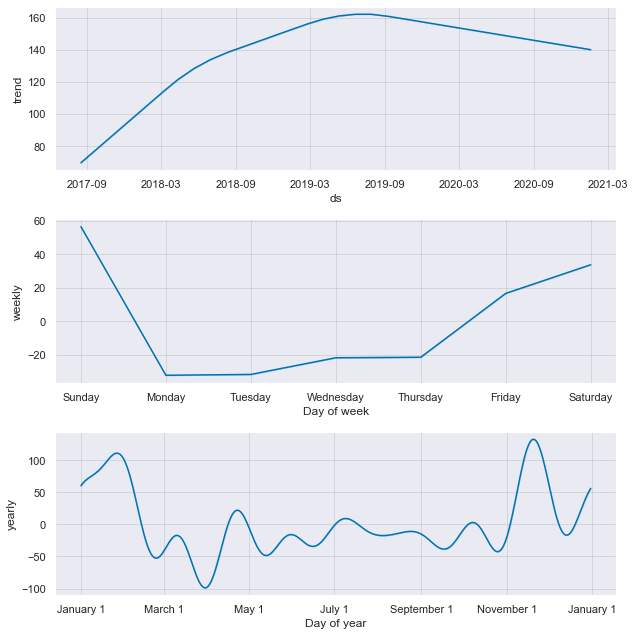

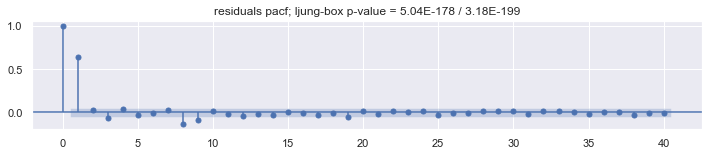

In [78]:
def prophet_show(store, df_train, cutoff_train, cutoff_eval, prophet_kwargs, title, 
                 plot_components=True, display_df=True):
    ts = pd.DataFrame(y_train).reset_index().rename(columns={'index':'ds', y_train.name:'y'})#getting time-series dataframe
    ind_train = pd.eval('ts.ds < cutoff_train') #getting training index
    ind_eval = ~ ind_train  #getting eval index
    len_train, len_eval = ind_train.sum(), ind_eval.sum() #len of data
    ts_train = ts.loc[ind_train]  #training ts
    m = Prophet(**prophet_kwargs) #init prophet
    m.fit(ts_train)
    ts_hat = m.predict(ts).merge(ts[['ds', 'y']], on='ds', how='left') #adding prediction
    if display_df: display(ts_hat.tail(3)) #print the finalized df
    # getting scores   
    df_combined = ts_hat.assign(smape=0, smape_smooth=0)
    df_combined.smape = smape_df(df_combined, average=False)
    df_combined.loc[ind_train, 'smape_smooth'] = lowess(df_combined.loc[ind_train, 'smape'], range(len_train), frac=0.03, return_sorted=False)
    df_combined.loc[ind_eval, 'smape_smooth'] = lowess(df_combined.loc[ind_eval, 'smape'], range(len_eval), frac=0.35, return_sorted=False)
    smape_in = df_combined.loc[ind_train].smape.mean()
    smape_oos = df_combined.loc[ind_eval].smape.mean()
    
    source = ColumnDataSource(data=df_combined)
    p = figure(plot_width=750, plot_height=200, title=("**{}**    store = {}     train / test = ..{} / ..{}"
                                                       .format(title, store, cutoff_train, cutoff_eval)), 
               x_axis_type='datetime', tools="pan,wheel_zoom,reset")
    _ = p.line(x='ds', y='yhat', source=source)
    _ = p.line(x='ds', y='yhat_lower', source=source, line_alpha=0.4)
    _ = p.line(x='ds', y='yhat_upper', source=source, line_alpha=0.4)
    _ = p.scatter(x='ds', y='y', source=source, color='black', radius=0.2, radius_dimension='y', alpha=0.4)
    _ = p.scatter(x='ds', y='y', source=source, color='black', radius=0.2, radius_dimension='y', alpha=0.4)
       
    deltas = np.abs(m.params['delta'][0])
    delta_max = np.max(deltas)
    df_deltas = pd.DataFrame({'ds': m.changepoints.values, 'delta':deltas, 'delta_scaled':ts_hat.yhat.mean() * deltas / delta_max})
    source2 = ColumnDataSource(df_deltas)
    cp1 = p.vbar(x='ds', source=source2, width=1, top=ts_hat.yhat.mean(), color='red', alpha=0.2, hover_color='red', hover_alpha=1)
    cp2 = p.vbar(x='ds', source=source2, width=1.5e+9, top='delta_scaled', color='red', alpha=0.5)
    p.add_tools(HoverTool(tooltips=[('trend delta', '@delta{.000}')], renderers=[cp2], mode='mouse'))
    # p.add_layout(Label(x=1e+10, y=10, text='xasfdfsdfsd'))
    p.add_layout(BoxAnnotation(left=ts_train.ds.iloc[-1], right=ts.ds.iloc[-1]))
    
    p2 = figure(plot_width=750, plot_height=100, title="SMAPE IS / OOS = {:.3f} / {:.3f}".format(smape_in, smape_oos), x_axis_type='datetime', tools="",
                x_range=p.x_range)
    sm1 = p2.line(x='ds', y='smape_smooth', source=source, color='green')
    p2.add_tools(HoverTool(tooltips=[('smape', '@smape')], renderers=[sm1], mode='vline', line_policy='interp'))
    p2.add_layout(BoxAnnotation(left=ts_train.ds.iloc[-1], right=ts.ds.iloc[-1]))
    p2.yaxis[0].ticker.desired_num_ticks = 2
    bokeh.io.output_notebook()
    bokeh.plotting.show(bokeh.layouts.column(p, p2))
    if plot_components:
        _ = m.plot_components(ts_hat, uncertainty=True)
        fig, ax = plt.subplots(1, 1, figsize=(12, 2))
#         res = ts_hat.query('ds < @cutoff_train').yhat - ts_train.y
        res = (df_combined['y'] - df_combined['yhat'])
#         adfuller_stat = statsmodels.tsa.stattools.adfuller(res.values)
        ljungbox_stat = statsmodels.stats.diagnostic.acorr_ljungbox(res.values)
        _ = statsmodels.graphics.tsaplots.plot_pacf(res, lags=40, ax=ax,
                                                    title='residuals pacf; ljung-box p-value = {:.2E} / {:.2E}'.format(ljungbox_stat[1][6], 
                                                                                                                      ljungbox_stat[1][30]))
    

prophet_show(store='Store level D',df_train = y_train.copy(), cutoff_train="2021-01-01", cutoff_eval="2021-01-14",
             prophet_kwargs={'yearly_seasonality':True, 'weekly_seasonality':True,
                            'uncertainty_samples':500},
            title='Prophet')